In [1]:
import itertools
import time
import os
import sys

In [2]:
import HTSeq
import pandas as pd

In [3]:
def invert_strand(iv):
    iv2 = iv.copy()
    if iv2.strand == "+":
        iv2.strand = "-"
    elif iv2.strand == "-":
        iv2.strand = "+"
    else:
        raise ValueError("Illegal strand")
    return iv2

In [4]:
# select gtf file: instantiate GFF_Reader Object
gtf_file = HTSeq.GFF_Reader("/gcm-lfs1/pablo/data/RNAdeg/annotation/gff/schizosaccharomyces_pombe.chr.extended.gff3")

In [5]:
# CIGAR match characters (including alignment match, sequence match, and
# sequence mismatch
com = ('M', '=', 'X')

In [6]:
## heterochromatic genes
htc_genes = ('dg1', 'dh1', 'after_tlh', 'MAT2', 'MAT3', 'MAT1')

# Counting gapped single-end reads:  **RNA-Seq data**

When sequencing RNA, many reads will pass over an **exon-exon junction** and hence **align to two (or more) disjunct intervals** on the genome, 
tyically with an intron in between. If the reads have been aligned with a **splice-aware alignment tool** (e.g. STAR), such gapped alignment is indicated in the `SAM` **file** by the `CIGAR` (Compact Idiosyncratic Gapped Alignment Report) **string**.

- Obtain `GenomicArrayOfSets` for the `exon` **features** from the `GFF` **File** (for `RNA` **stranded**)

In [151]:
# instantiate `GenomicArrayOfSets` for the `exons` features: (for `RNA` **stranded**)
#exon_features = HTSeq.GenomicArrayOfSets("auto", stranded=True)
exon_features = HTSeq.GenomicArrayOfSets("auto", stranded=False) ## Parastou used this instead!

genes_dict = {}

## loop over all features in gtf file
for feature in gtf_file:
    
    ## store all exons in our `GenomicArrayOfSets`
    if feature.type == "exon":
        
        ## identify each `exon` feature by parent transcript/gene
        gene_id = feature.attr["Parent"].split(':')[1][:-2] ## get rid of '.1'

        exon_features[feature.iv] += gene_id

        # Is this the first time we see this gene?
        if gene_id not in genes_dict:
            # If so, add to the 'genes_dict' an empty list 
            genes_dict[ gene_id ] = list()

        # add the feature to the gene list
        genes_dict[ gene_id ].append( feature )

In [66]:
len(genes_dict)

6992

![img_overlap](https://htseq.readthedocs.io/en/release_0.11.1/_images/count_modes.png)

- Parse `BAM` **File** to **count reads** falling into each `exon` **feature** 

In [96]:
#sample_name = '1113_pA'
sample_name = '1168_pA'

In [168]:
import collections
counts = collections.Counter( )

start_time = time.time()

# select bam file: instantiate BAM_Reader Object (RNA-seq)
#bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data/RNA/bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam'))
bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/old_data/RNA/tagged_bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.tagged.bam'))

## -------
## Options
## -------

minaqual = 10

## How to deal with overlap of READ and FEATURE
overlap_mode = "union"
#overlap_mode = "intersection-nonempty"
#overlap_mode = "intersection-strict"

## How to deal with overlapping FEATURES and multimapped reads
#multimapped_mode = 'all'
multimapped_mode = 'fractional'
#multimapped_mode = 'none'

## How to deal with multimapped reads (secondary alignments!)
#secondary_alignment_mode = 'ignore'
secondary_alignment_mode = 'none'

i = 0

#for aln in itertools.islice(bam_file, 10000):
for aln in bam_file:

    if i > 0 and i % 100000 == 0:
        sys.stderr.write("{} alignment records processed. {} s\n".format(i,  time.time() - start_time))
        sys.stderr.flush()
    i += 1          
    
    ## ----------------------
    ## Inspect read alignment
    ## ----------------------
    
    ## _mapped or _unmapped (our BAM files only contain _mapped)
    counts["_total"] += 1
    
    if not aln.aligned:
        import pdb
        pdb.set_trace()
        counts["_unmapped"] += 1
        ## skips to next iteration
        continue
        
    ## Multimapped reads are contained as separate entries in the BAM file.
    try:
        if aln.optional_field("NH") > 1 and aln.optional_field("NH") <= 15:
            counts["_alignment_not_unique"] += 1
            
            if multimapped_mode == 'none':
                ## skips to next iteration
                continue
                
            elif ((secondary_alignment_mode == 'ignore') and aln.not_primary_alignment):
                counts["_not_primary_alignment"] += 1
                ## skips to next iteration
                continue
                
        elif aln.optional_field("NH") > 15:
            counts["_ignore_alignment"] += 1
            
            ## skips to next iteration
            continue

    except KeyError:
        pass

    #if aln.aQual < minaqual:
    #    #import pdb
    #    #pdb.set_trace()
    #    counts["_too_low_aQual"] +=  1
    #    continue

    ## -----------------------------
    ## Read and Feature Overlap Mode
    ## -----------------------------
    
    ## invert strand - due to sequencing is strand is reversed!
    iv_seq = (invert_strand(co.ref_iv) for co in aln.cigar if (co.type in com and co.size > 0))
    #iv_seq = (co.ref_iv for co in aln.cigar if (co.type in com and co.size > 0))
    
    ## loop over CIGAR operations (cig_op) for aligned read    

    ## A. Union: the union of all the sets S(i). This mode is recommended for most use cases.
    if overlap_mode == "union":
        ## feature set
        gene_ids = set()
        
        for iv in iv_seq:
            #if iv.chrom not in exon_features.chrom_vectors:
            #    raise UnknownChrom
            
            for iv2, fs in exon_features[ iv ].steps():
                gene_ids = gene_ids.union(fs)

    ## B. Intersection-strict: the intersection of all the sets S(i).
    ## C. Intersection-nonempty: the intersection of all non-empty sets S(i).
    elif overlap_mode in ("intersection-strict", "intersection-nonempty"):
        ## feature set
        gene_ids = None
        
        for iv in iv_seq:
            #if iv.chrom not in exon_features.chrom_vectors:
            #    raise UnknownChrom
            
            for iv2, fs in exon_features[ iv ].steps():
                if ((len(fs) > 0) or (overlap_mode == "intersection-strict")):
                    if gene_ids is None:
                        gene_ids = fs.copy()
                    else:
                        gene_ids = gene_ids.intersection(fs)
                    
    ## Other: Ilegal!                   
    else:
        sys.exit("Illegal overlap mode.")
    
    ## --------------
    ## Count Features
    ## --------------
    
    ## A. Mapped to unknown feature (it is empty)
    if gene_ids is None or len(gene_ids) == 0:
        #import pdb
        #pdb.set_trace()
        counts["_no_feature"] += 1
        
    ## B. Mapped to a region with overlapping features (contains more than one element)
    ## See next how to deal with this ambiguous read alignments! (multimapped_mode)
    elif len(gene_ids) > 1:
        counts["_ambiguous"] += 1
    
    ## Deal with reads mapped to region with overlapping features!
    if gene_ids is not None and len(gene_ids) > 0:
        
        ## - ignore reads mapped to region with overlapping features!
        if multimapped_mode == 'none':
            
            ## C. Uniquely Mapped (contains exactly one element) 
            if len(gene_ids) == 1:
                counts[list(gene_ids)[0]] += 1
        
        ## - count each multimapped feature once
        elif multimapped_mode == 'all':
            
            ## D. Multi Mapped
            for fsi in list(gene_ids):
                counts[ fsi ] += 1
                
        ## - count each multimapped feature a fractio
        elif multimapped_mode == 'fractional':
            
            ## D. Multi Mapped
            for fsi in list(gene_ids):
                counts[ fsi ] += 1 / aln.optional_field('NH')

        ## Other: Ilegal!                   
        else:
            sys.exit("Illegal multimap mode.")

print('Elapsed Time (Counting reads):', time.time() - start_time)

100000 alignment records processed. 5.148064374923706 s
200000 alignment records processed. 10.611220836639404 s
300000 alignment records processed. 15.98412275314331 s
400000 alignment records processed. 21.070789098739624 s
500000 alignment records processed. 26.10773253440857 s
600000 alignment records processed. 31.32817554473877 s
700000 alignment records processed. 36.56236934661865 s
800000 alignment records processed. 41.88441467285156 s
900000 alignment records processed. 47.05519652366638 s
1000000 alignment records processed. 52.630645513534546 s
1100000 alignment records processed. 57.98696780204773 s
1200000 alignment records processed. 63.21794009208679 s
1300000 alignment records processed. 68.13604068756104 s
1400000 alignment records processed. 73.07154846191406 s
1500000 alignment records processed. 78.13472437858582 s
1600000 alignment records processed. 83.1444799900055 s
1700000 alignment records processed. 88.29799723625183 s
1800000 alignment records processed. 9

Elapsed Time (Counting reads): 181.87013912200928


In [169]:
#{k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

- Convert `counter` to **DataFrame**

In [170]:
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
counts_df = counts_df.rename(columns={'index':'gene-id', 0:'count'})
counts_df.head(20)

,gene-id,count
0,_total,3.408617e+06
1,_alignment_not_unique,1.574200e+05
2,SPAC212.11,3.736667e+01
3,SPAC212.10,5.750000e+00
4,SPAC212.09c,8.191667e+01
5,SPNCRNA.70,3.333333e-01
6,SPAC212.08c,1.805000e+02
7,SPAC212.07c,1.000000e+00
8,SPAC212.12,1.001667e+02
9,SPAC212.06c,2.633333e+01


In [171]:
counts_df.shape

(6690, 2)

- Summary of counts

In [172]:
counts_df[counts_df['gene-id'].str.startswith('_')]

,gene-id,count
0,_total,3408617.0
1,_alignment_not_unique,157420.0
17,_no_feature,1957.0
19,_ambiguous,1002946.0


In [173]:
## now contains multiple counting
counts_df[~counts_df['gene-id'].str.startswith('_')]['count'].sum()

4411329.713095238

- Show counts for genes of interest: **Heterochromatic Genes**

In [174]:
counts_df[counts_df['gene-id'].isin(htc_genes)]

,gene-id,count
2047,dh1,11.250000
2049,dg1,8.611111
4138,MAT1,209.000000
4151,MAT2,40.000000
4155,MAT3,188.500000
5461,after_tlh,108.000000


## Compare results with **Parastou's counting**

- Results using **Parastou's counting script**

In [175]:
#xp_rna = '/gcm-lfs1/pablo/data/RNAdeg/data/RNA/xp_data/pombe_gene_count_matrix.csv'
xp_rna = '/gcm-lfs1/pablo/data/RNAdeg/old_data/RNA/xp_data/pombe_gene_count_matrix.csv'

In [176]:
xp_rna_df = pd.read_csv(xp_rna, sep='\t')
xp_rna_df = xp_rna_df[['gene-id', 'length', 'type', 'category', 'bio_type', sample_name]].astype({sample_name: 'int64'})
xp_rna_df.head()

,gene-id,length,type,category,bio_type,1168_pA
0,SPAC212.11,5661.0,gene,repeat,protein_coding,80
1,SPAC212.10,605.0,pseudogene,repeat,pseudogene,10
2,SPAC212.09c,1655.0,pseudogene,repeat,pseudogene,219
3,SPNCRNA.70,529.0,ncRNA_gene,repeat,ncRNA,1
4,SPAC212.08c,1210.0,gene,repeat,protein_coding,476


In [177]:
total = xp_rna_df[sample_name].sum()
total

3254080

- **Merge** both counts DataFrames

In [178]:
merged_xp_rna = pd.merge(counts_df, xp_rna_df, on='gene-id', how='outer')
merged_xp_rna

,gene-id,count,length,type,category,bio_type,1168_pA
0,_total,3.408617e+06,NaN,NaN,NaN,NaN,NaN
1,_alignment_not_unique,1.574200e+05,NaN,NaN,NaN,NaN,NaN
2,SPAC212.11,3.736667e+01,5661.0,gene,repeat,protein_coding,80.0
3,SPAC212.10,5.750000e+00,605.0,pseudogene,repeat,pseudogene,10.0
4,SPAC212.09c,8.191667e+01,1655.0,pseudogene,repeat,pseudogene,219.0
...,...,...,...,...,...,...,...
6944,SPMITTRNAARG.02,NaN,72.0,tRNA_gene,gene,tRNA,0.0
6945,SPMITTRNAILE.02,NaN,71.0,tRNA_gene,gene,tRNA,0.0
6946,SPMITTRNASER.02,NaN,81.0,tRNA_gene,gene,tRNA,0.0
6947,SPMITTRNAALA.01,NaN,72.0,tRNA_gene,gene,tRNA,0.0


- Bigger differences

In [179]:
merged_xp_rna['diff_count'] = abs(merged_xp_rna['count'] - merged_xp_rna[sample_name])

In [180]:
merged_xp_rna.sort_values('diff_count', na_position='first')

,gene-id,count,length,type,category,bio_type,1168_pA,diff_count
0,_total,3.408617e+06,NaN,NaN,NaN,NaN,NaN,NaN
1,_alignment_not_unique,1.574200e+05,NaN,NaN,NaN,NaN,NaN,NaN
17,_no_feature,1.957000e+03,NaN,NaN,NaN,NaN,NaN,NaN
19,_ambiguous,1.002946e+06,NaN,NaN,NaN,NaN,NaN,NaN
85,SPRRNA.10,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2631,SPNCRNA.1030,1.154000e+04,1320.0,ncRNA_gene,gene,ncRNA,5763.0,5777.000000
6220,SPCC13B11.01,4.330433e+04,3462.0,gene,gene,protein_coding,10827.0,32477.333333
6221,SPCC13B11.02c,4.330333e+04,3822.0,gene,gene,protein_coding,10825.0,32478.333333
6222,SPNCRNA.2001,4.330533e+04,3958.0,ncRNA_gene,gene,ncRNA,10826.0,32479.333333


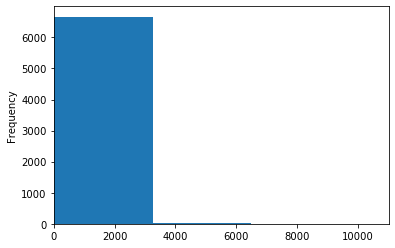

In [181]:
merged_xp_rna['diff_count'].plot.hist(xlim=(0, 11000))

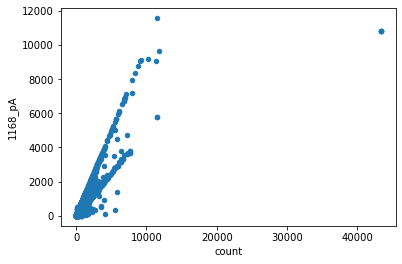

In [182]:
#merged_xp_rna.plot.scatter(x = 'count', y = sample_name, xlim=(0, 1000), ylim=(0, 1000))
merged_xp_rna.plot.scatter(x = 'count', y = sample_name,)

- Show counts for genes of interest: **Heterochromatic Genes**

In [183]:
merged_xp_rna[merged_xp_rna['gene-id'].isin(htc_genes)]

,gene-id,count,length,type,category,bio_type,1168_pA,diff_count
2047,dh1,11.250000,4000.0,gene,repeat,protein_coding,37.0,25.750000
2049,dg1,8.611111,3500.0,gene,repeat,protein_coding,30.0,21.388889
4138,MAT1,209.000000,1500.0,gene,repeat,protein_coding,211.0,2.000000
4151,MAT2,40.000000,4000.0,gene,repeat,protein_coding,35.0,5.000000
4155,MAT3,188.500000,4000.0,gene,repeat,protein_coding,182.0,6.500000
5461,after_tlh,108.000000,5000.0,gene,repeat,protein_coding,111.0,3.000000


## Tests

- Find **read alignments** mapping to a specific set of features

In [113]:
# instantiate `GenomicArrayOfSets` for the `exons` features: (for `RNA` **stranded**)
#test_features = HTSeq.GenomicArrayOfSets("auto", stranded=True)
test_features = HTSeq.GenomicArrayOfSets("auto", stranded=False)

genes_dict = {}

## loop over all features in gtf file
for feature in gtf_file:
    
    ## store all exons in our `GenomicArrayOfSets`
    if feature.type == "exon":
        
        ## identify each `exon` feature by parent transcript/gene
        gene_id = feature.attr["Parent"].split(':')[1][:-2] ## get rid of '.1'
        
        if gene_id in htc_genes:

            test_features[ feature.iv ] += gene_id

            # Is this the first time we see this gene?
            if gene_id not in genes_dict:
                # If so, add to the 'genes_dict' an empty list 
                genes_dict[ gene_id ] = list()

            # add the feature to the gene list
            genes_dict[ gene_id ].append( feature )

In [114]:
genes_dict

{'dg1': [<GenomicFeature: exon 'gene:dg1' at I: 3764499 -> 3760998 (strand '-')>],
 'dh1': [<GenomicFeature: exon 'gene:dh1' at I: 3756999 -> 3752998 (strand '-')>],
 'after_tlh': [<GenomicFeature: exon 'gene:after_tlh' at II: 4538999 -> 4533998 (strand '-')>],
 'MAT2': [<GenomicFeature: exon 'gene:MAT2' at II: 2132999 -> 2128998 (strand '-')>],
 'MAT3': [<GenomicFeature: exon 'gene:MAT3' at II: 2136999 -> 2132998 (strand '-')>],
 'MAT1': [<GenomicFeature: exon 'gene:MAT1' at II: 2115499 -> 2113998 (strand '-')>]}

In [115]:
overlap_feature = genes_dict['MAT2'][0]

In [116]:
#sample_name = '1113_pA'
sample_name = '1168_pA'

In [117]:
start_time = time.time()

# select bam file: instantiate BAM_Reader Object (RNA-seq)
bam_file = HTSeq.BAM_Reader(os.path.join('/gcm-lfs1/pablo/data/RNAdeg/data/RNA/bams', sample_name, sample_name + '.Aligned.sortedByCoord.out.bam'))

## -------
## Options
## ------- 

i = 0

reads = {}

#for aln in itertools.islice(bam_file, 1600000, 1700000):
for aln in bam_file:
    
    #import pdb
    #pdb.set_trace()

    if i > 0 and i % 100000 == 0:
        sys.stderr.write("{} alignment records processed. {} s\n".format(i,  time.time() - start_time))
        sys.stderr.flush()
    i += 1
                
    ## ----------------------
    ## Inspect read alignment
    ## ----------------------
    
    ## invert strand - due to sequencing is strand is reversed!
    iv_seq = (invert_strand(co.ref_iv) for co in aln.cigar if (co.type in com and co.size > 0))
    #iv_seq = (co.ref_iv for co in aln.cigar if (co.type in com and co.size > 0))
    
    gene_ids = set()
    gene_ids_reduced = set()
    
    alignment_fs = {}
        
    jj = 0
    ## loop over CIGAR operations (cig_op) for aligned read 
    for iv in iv_seq:
        
        jj += 1

        if (iv.chrom == overlap_feature.iv.chrom) and (iv.end >= overlap_feature.iv.start)  and (iv.start <= overlap_feature.iv.end):
            
            #if jj >1:
            #    import pdb
            #    pdb.set_trace()
            
            fs = set()
                         
            for iv2, fs2 in exon_features[ iv ].steps():
                gene_ids = gene_ids.union(fs2)
                #print(iv2, fs2)
                
            for iv2, fs2 in test_features[ iv ].steps():
                gene_ids_reduced = gene_ids_reduced.union(fs2)
                fs = fs.union(fs2)
                #print(iv2, fs2)
            
            alignment_fs[jj] = fs

    if len(alignment_fs) > 0:
        
        alignment_fs['gene_ids'] = gene_ids
        alignment_fs['gene_ids_reduced'] = gene_ids_reduced
        
        alignment_fs['NH']= aln.optional_field("NH")
        alignment_fs['alignment'] = aln

        read_name = aln.read.name
        
        #if read_name not in reads.keys():
        assert read_name not in reads.keys()
        #reads[read_name] = {}   
        reads[read_name] = alignment_fs

    #else:
    #    ky = '-'.join(sorted(list(gene_ids_reduced)))

    #    if ky not in multi_aligned_reads.keys():
    #        multi_aligned_reads[ky] = {}
    #    multi_aligned_reads[ky][aln.read.name] = aln


print('Elapsed Time (Counting reads):', time.time() - start_time)

100000 alignment records processed. 1.45521879196167 s
200000 alignment records processed. 2.9313876628875732 s
300000 alignment records processed. 4.411110877990723 s
400000 alignment records processed. 5.869096279144287 s
500000 alignment records processed. 7.261061906814575 s
600000 alignment records processed. 8.715775966644287 s
700000 alignment records processed. 10.164191246032715 s
800000 alignment records processed. 11.5581636428833 s
900000 alignment records processed. 13.015530586242676 s
1000000 alignment records processed. 14.428688287734985 s
1100000 alignment records processed. 15.822635650634766 s
1200000 alignment records processed. 17.230992317199707 s
1300000 alignment records processed. 18.653667211532593 s
1400000 alignment records processed. 20.069377422332764 s
1500000 alignment records processed. 21.5571928024292 s
1600000 alignment records processed. 23.057801485061646 s
1700000 alignment records processed. 24.540045738220215 s
1800000 alignment records process

Elapsed Time (Counting reads): 50.6607940196991


In [118]:
len(reads)

36

In [119]:
reads.keys()

dict_keys(['L183:365:CBF20ANXX:6:2209:9784:51525:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2209:11731:8029:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1210:3334:51173:1:Y:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1307:7211:69628:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2110:4363:14087:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2108:20607:14348:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2301:5203:62810:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2209:3431:99503:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1305:13966:12841:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1113:5035:21196:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1206:8002:38821:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1204:18755:41536:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1316:4551:6124:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1201:18976:23791:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2303:6998:82477:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1302:16959:84250:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:1107:9334:70256:1:N:0:0:CAGGCG', 'L183:365:CBF20ANXX:6:2207:13785:62947:1:N:0:0:CAG

In [120]:
reads['L183:365:CBF20ANXX:6:2209:11731:8029:1:N:0:0:CAGGCG']

{1: {'MAT2'},
 'gene_ids': {'MAT2', 'SPNCRNA.389'},
 'gene_ids_reduced': {'MAT2'},
 'NH': 2,
 'alignment': <SAM_Alignment object: Read 'L183:365:CBF20ANXX:6:2209:11731:8029:1:N:0:0:CAGGCG' aligned to II:[2129911,2129961)/->}

In [121]:
for ii, vv in reads.items():
    print(vv)

{2: {'MAT2'}, 'gene_ids': {'MAT2'}, 'gene_ids_reduced': {'MAT2'}, 'NH': 4, 'alignment': <SAM_Alignment object: Read 'L183:365:CBF20ANXX:6:2209:9784:51525:1:N:0:0:CAGGCG' aligned to II:[1104943,2131897)/+>}
{1: {'MAT2'}, 'gene_ids': {'MAT2', 'SPNCRNA.389'}, 'gene_ids_reduced': {'MAT2'}, 'NH': 2, 'alignment': <SAM_Alignment object: Read 'L183:365:CBF20ANXX:6:2209:11731:8029:1:N:0:0:CAGGCG' aligned to II:[2129911,2129961)/->}
{1: {'MAT2'}, 'gene_ids': {'MAT2', 'SPNCRNA.389'}, 'gene_ids_reduced': {'MAT2'}, 'NH': 2, 'alignment': <SAM_Alignment object: Read 'L183:365:CBF20ANXX:6:1210:3334:51173:1:Y:0:0:CAGGCG' aligned to II:[2129925,2129975)/->}
{1: {'MAT2'}, 'gene_ids': {'MAT2', 'SPNCRNA.389'}, 'gene_ids_reduced': {'MAT2'}, 'NH': 2, 'alignment': <SAM_Alignment object: Read 'L183:365:CBF20ANXX:6:1307:7211:69628:1:N:0:0:CAGGCG' aligned to II:[2130452,2130502)/->}
{1: {'MAT2'}, 'gene_ids': {'MAT2'}, 'gene_ids_reduced': {'MAT2'}, 'NH': 2, 'alignment': <SAM_Alignment object: Read 'L183:365:CBF20

In [122]:
gene_ids = None

for iv, fs in exon_features[reads['L183:365:CBF20ANXX:6:1110:19280:36437:1:N:0:0:CAGGCG']['alignment'].iv].steps():
    print(iv, fs)

    if ((len(fs) > 0) or (overlap_mode == "intersection-strict")):
        if gene_ids is None:
            gene_ids = fs.copy()
        else:
            gene_ids = gene_ids.union(fs)

print(gene_ids)

II:[2132954,2132999)/. {'SPBC1711.02', 'MAT2'}
II:[2132999,2133000)/. {'SPBC1711.02', 'MAT3', 'MAT2'}
II:[2133000,2133003)/. {'SPBC1711.02', 'MAT3'}
{'SPBC1711.02', 'MAT3', 'MAT2'}


In [126]:
nh = []

start_time = time.time()
i = 0
#for aln in itertools.islice(bam_file, 10000):
for aln in bam_file:

    if i > 0 and i % 100000 == 0:
        sys.stderr.write("{} alignment records processed. {} s\n".format(i,  time.time() - start_time))
        sys.stderr.flush()
    i += 1          
        
    ## Multimapped reads are contained as separate entries in the BAM file.
    nh.append( aln.optional_field("NH") )

print('Elapsed Time (parsing reads):', time.time() - start_time)

100000 alignment records processed. 268.18972301483154 s
200000 alignment records processed. 269.1396098136902 s
300000 alignment records processed. 270.1076776981354 s
400000 alignment records processed. 271.0638234615326 s
500000 alignment records processed. 272.05218982696533 s
600000 alignment records processed. 273.02886414527893 s
700000 alignment records processed. 274.006733417511 s
800000 alignment records processed. 274.9754321575165 s
900000 alignment records processed. 275.946084022522 s
1000000 alignment records processed. 276.92605328559875 s
1100000 alignment records processed. 277.9127058982849 s
1200000 alignment records processed. 278.8938512802124 s
1300000 alignment records processed. 279.88550305366516 s
1400000 alignment records processed. 280.84897661209106 s
1500000 alignment records processed. 281.8468029499054 s
1600000 alignment records processed. 282.8613679409027 s
1700000 alignment records processed. 283.8855996131897 s
1800000 alignment records processed.

Elapsed Time (parsing reads): 302.0639624595642


In [128]:
import matplotlib.pyplot as plt

(array([2.863813e+06, 8.456400e+04, 4.350300e+05, 5.664400e+04,
        5.836000e+04, 4.026000e+03, 1.484000e+03, 1.384000e+03,
        9.810000e+02, 1.490000e+03]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

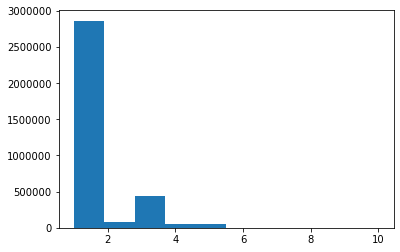

In [129]:
plt.hist(nh)

In [130]:
print('Min:', min(nh), 'Max:', max(nh))

Min: 1 Max: 10
